# Markov Chain Monte Carlo (MCMC)


* Review
* Central insight of MCMC
* Metropolis-Hastings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

%matplotlib inline

## Review

We briefly review some of the material we discussed previously to refresh prior to our discussion of Markov chain Monte Carlo methods.

**Bayesian statistics**

A Bayesian statistician builds a single model, $P(\theta, Y)$ and updates their beliefs about $\theta$ (a random variable) by conditioning on realizations of $Y$ (also a random variable)

The distribution $P(\theta | Y)$, which expresses the distribution of the parameter $\theta$ conditional on observed data, is known as the _posterior_

Bayes law tells us how to compute the posterior,

$$P(\theta | Y) = \frac{\overbrace{P(Y | \theta)}^{\text{likelihood}} \overbrace{P(\theta)}^{\text{prior}}}{\underbrace{P(Y)}_{\text{Marginal distribution of $Y$}}}$$

* _likelihood_: The conditional distribution that describes the random variable $Y$ conditional on a given $\theta$
* _prior_: The prior distribution is the marginal distribution that describes our beliefs about how likely certain values of $\theta$ are
* _Marginal distribution of $Y$_: The marginal distribution of $Y$ -- The marginal distribution of $Y$ is often ignored in Bayesian computations with the justification that the posterior is proportional to the product of the likelihood and prio.

**Using the posterior**: The posterior distribution is used to make inferences about how likely certain values of $\theta$ are (conditional on what has been observed)

- Credible sets: Let $\tilde{y} \sim f(Y | \theta)$ then an $\alpha$ credible set is a set $C_{\alpha}$ such that $\text{Prob}(\theta \in C_{\alpha}) \equiv \int_{\theta \in C_{\alpha}} P(\theta | \tilde{y}) d \theta = \alpha$
  - Highest posterior interval
  - Equal-tailed interval
- Posterior allows us to answer questions such as, "given the observed data, how likely is it that $\theta > 0$?"

**Finding the posterior**: Seems easy, but it can difficult

* Conjugate priors: For certain likelihoods, one can find a conjugate prior such that the posterior is in the same family of distributions as the prior. You can describe the posterior in terms of updated parameters
* Markov chain Monte Carlo: What we will talk about today

### Markov chains


**What is a Markov chain?**

A Markov chain is a stochastic pprocess that satisfies the Markov property which states $\text{Prob}(x_t=x | \{x_0, x_1, \dots, x_{t-1}\}) = \text{Prob}(x_t=x | x_{t-1})$

**Transition kernel**

The transition kernel is defined by $\phi(x, A) \equiv \text{Prob}(x_{t+1} \in A | x_t = x) = \int_{x_{t+1} \in A} f(x_{t+1} | x_t) d x_{t+1}$

**Stationary distribution**

A stationary distribution, $\phi^*(x)$, is a probability distribution such that $\phi^*(A) = \int_{y} \phi^*(y) \phi(y, A) dy$ -- That is, the probability of being in any subset of outcomes under the stationary distribution ($\phi^*(A)$) is equivalent to the total probability of transitioning into that subset from anywhere else in the distribution ($\int_{y} \phi^*(y) \phi(y, A) dy$).

Under certain conditions (e.g. aperiodic and irreducible), a Markov chain has a unique stationary distribution.

## Central Idea of MCMC

The central insight of MCMC is that, if we could sample from the posterior distribution, then we could approximate various statistics of interest using these samples

However, unless we have chosen a very special case (e.g. conjugate-priors), we can't even determine the distribution class of the posterior, much less sample from it

MCMC methods will build Markov chains that have a stationary distribution that corresponds to the posterior

## Metropolis (et al.) - Hastings

Versions of the algorithm were originally proposed in a pair of papers:

1. _Equation of State Calculations by Fast Computing Machines_ by Nicholas Metropolis, Arianna W. Rosenbluth, Marshall Rosenbluth, Augusta H. Teller, Edward Teller
2. _Monte Carlo Sampling Methods Using Markov Chains and Their Applications_ by W. K. Hastings

This method can be used to sample from a probability distribution when direct sampling is difficult (such as with a non-conjugate posterior).

The steps of the algorithm can be broken into a few steps:

1. Initialize
2. Iterate
  - New candidate
  - Acceptance ratio
  - Accept or reject



Let $f^*(\theta | \tilde{y})$ be a function that is proportional to the desired probability distribution $f(\theta | \tilde{y})$.

In particular, we will use

$$f^*(\theta | \tilde{y}) \equiv f(\tilde{y} | \theta) f(\theta) = f(\theta | \tilde{y}) f(\tilde{y}) \propto \frac{f(\tilde{y} | \theta) f(\theta)}{f(\tilde{y})}$$

**Step 1**: Initialize

In order to initialize the algorithm, we need two components:

1. An initial value $\theta_0$ to start the Markov chain.
  - One way to initialize the Markov chain is by drawing a sample from your prior!


2. A proposal density, $g(\theta' | \theta_t)$ that will propose new values $\theta'$ given curent value $\theta_t$
  - In what follows, we will assume $g$ is a symmetric distribution, i.e. $g(\theta' | \theta_t) = g(\theta_t | \theta')$, but this is not necessary
  - It is common to choose $g(\theta' | \theta_t)$ to be a normal distribution with mean $\theta_t$ (which makes the sequence of samples a random walk)

In [ ]:
def initial_theta(prior):
    "Draws a sample from the prior"
    return prior.rvs()


def normal_proposal_density(theta, sigma):
    """
    Proposes a new theta given the current theta and
    standard deviation of the proposal density
    """
    return st.norm(loc=theta, scale=sigma).rvs()

**Step 2**: Iterate

The iteration step is itself composed of 3 steps:

2.1 Generate a candidate proposal, $\theta'$, by sampling from $g(\theta' | \theta_t)$

2.2 Calculate the _acceptance ratio_, $\alpha(\theta', \theta_t) \equiv f(\theta' | \tilde{y}) / f(\theta_t | \tilde{y})$

2.3 Accept or reject. Draw $u \sim \text{U}[0, 1]$ then accept proposal $\theta'$ if $u \leq \alpha$, otherwise reject.

In [ ]:
def mh_step(theta, fstar, proposer):
    "The one-step iteration of the MH algorithm"
    # Propose a new theta
    theta_proposal = proposer(theta)

    # Compute the acceptance ratio
    alpha = fstar(theta_proposal) / fstar(theta)

    # Accept or reject
    return (theta_proposal, 1) if np.random.rand() < alpha else (theta, 0)

**Wait... What is going on...**

_Want_: Samples from $f(\theta | \tilde{y})$

_What we are generating_: Samples from a Markov chain

We won't do it today so that we can leave time for examples, but one can show that the stationary distribution for the Markov chain described above (sample from a symmetric distribution and accept with the probability given by the acceptance ratio) is the posterior.

**Putting it all together**

We can then define a "runner" function that will take our steps and put them together.

In [ ]:
def rw_mh_algorithm(prior, likelihood, sigma=0.5, Nburn=1_000, N=500):

    # Draw initial theta
    theta_0 = initial_theta(prior)

    # Create the fstar and proposer func
    fstar = lambda theta: prior.pdf(theta) * likelihood(theta)
    proposer = lambda theta: normal_proposal_density(theta, sigma)

    # Burn in the Markov chain
    for t in range(Nburn):
        theta_0, foo = mh_step(theta_0, fstar, proposer)

    # Generate sample
    accept_out = np.empty(N, dtype=int)
    accept_out[0] = 1
    theta_out = np.empty(N)
    theta_out[0] = theta_0
    for t in range(1, N):
        theta_out[t], accept_out[t] = mh_step(
            theta_out[t-1], fstar, proposer
        )

    return theta_out, accept_out

### Example:

It's always a good idea to begin with an example that we already know the answer to. Let's turn to one of our conjugate prior pairs and use it as a testing ground for our new algorithm.

Let's return to our Beta-Binomial conjugate pair.

* Prior: $f(p) = \text{Beta}(\alpha, \beta)$
* Likelihood: $f(k | p) = {n \choose{k}} p^k (1 - p)^{n-k}$

Then we know that the posterior is given by

* Posterior: $f(p | k) = \text{Beta}(\alpha + k, \beta + (n - k))$

In [ ]:
# Likelhood parameter
n = 5

# Hyperparameters
alpha, beta = 1.0, 1.0

# Observed data
k = 4

prior = st.beta(alpha, beta)
likelihood = lambda _p: st.binom(n, _p).pmf(k)
posterior = st.beta(alpha + k, beta + (n-k))

**Visualization the algorithm**

We plot a short history of steps below. In each of these steps, if a value is green, then it was an accepted proposal and if the value is red, then it was a rejected proposal


In [ ]:
p_mh, accept_mh = rw_mh_algorithm(prior, likelihood, sigma=0.05, Nburn=2_000, N=2_000)
print(f"Accepted {100*np.mean(accept_mh):0.2f} percent of samples")

In [ ]:
nstart = 5
nsteps = 100

fig, ax = plt.subplots()

colors = np.array(["red", "green"])[accept_mh[nstart:nstart+nsteps]]
ss = np.array([40.0, 15.0])[accept_mh[nstart:nstart+nsteps]]
values = p_mh[nstart+1:nsteps+nstart+1]

xvals = np.arange(nsteps)
ax.scatter(xvals, values, c=colors, s=ss, alpha=0.75)

# Set a non-white face color to help contrast colors
ax.set_facecolor((0.95, 0.95, 0.95))

Do you notice anything that seems concerning?

* Samples are correlated

We can cut down the correlation in two ways:

1. Increase $\sigma$ which means the movements are larger
  - A rule of thumb is that the random walk Metropolis-Hastings algorithm should accept approximately 80% of the proposals


2. Only keep every $n$th sample



In [8]:
p_mh, accept_mh = rw_mh_algorithm(prior, likelihood, sigma=0.09, Nburn=2_000, N=10_000)
print(f"Accepted {100*np.mean(accept_mh):0.2f} percent of samples")

Accepted 83.38 percent of samples


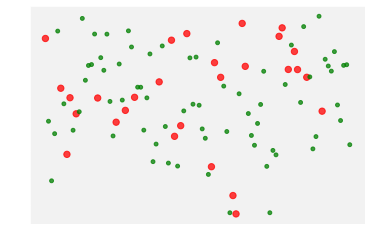

In [9]:
njump = 10
p_mh_jump, accept_mh_jump = p_mh[::njump], accept_mh[::njump]

nstart = 5
nsteps = 100

fig, ax = plt.subplots()

colors = np.array(["red", "green"])[accept_mh_jump[nstart:nstart+nsteps]]
ss = np.array([40.0, 15.0])[accept_mh_jump[nstart:nstart+nsteps]]
values = p_mh_jump[nstart+1:nsteps+nstart+1]

xvals = np.arange(nsteps)
ax.scatter(xvals, values, c=colors, s=ss, alpha=0.75)

# Set a non-white face color to help contrast colors
ax.set_facecolor((0.95, 0.95, 0.95))

**Comparing the MH posterior with the analytical posterior**

In the graph below we plot the pdf of the analytical posterior against a histogram of draws from the MH posterior

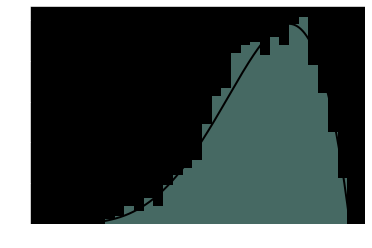

In [10]:
fig, ax = plt.subplots()

# Plot the histogram
ax.hist(p_mh_jump, alpha=0.5, density=True, bins=25)

# Plot the pdf
x = np.linspace(0.0, 1.0, 500)
ax.plot(x, posterior.pdf(x), linewidth=2.0, color="k")

## Other MCMC Algorithms

There are many different MCMC algorithms (many of which perform better than the Metropolis-Hastings algorithm). For example,

* Adaptive Metropolis-Hastings
* Gibbs Sampler
* Hamiltonian Monte Carlo (HMC)
* No U-Turn Sampler (NUTS)

We are particularly optimistic about the NUTS algorithm which is the default in many "probabilistic programming languages".

We invite you to explore some of these algorithms with this (excellent) [online tool](https://chi-feng.github.io/mcmc-demo/app.html) develolped by [Chi Feng](https://github.com/chi-feng)